# Errores en imágenes reales


In [8]:
%reload_ext autoreload
%autoreload 2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from stitch import Patch, Picture, FPMPicture
from fpmsample.simicro import RealMicroscope
from phasemath import math as pmath
from phaseopt.containers import Options, ResultsContainer
from phaseopt.phaseopt import solve
import skimage.io as io


dirname = '20190730_105553'
#dirname = '20190808_152108
# dirname = '20190808_164911'
#dirname = '20190814_105554'
rm = RealMicroscope.from_dirname(dirname=dirname)
overlap = 55
pic_lr = Picture.from_microscope(rm, overlap=overlap)
pic_hr = FPMPicture.from_microscope(rm, overlap=overlap)
opts = Options(record_rss=True, record_angular_rss=True, xt=None)
results = ResultsContainer(opts)

rm.details()

Original size: 1250
Pupil radius: 44 pixels
mk: 5, patch size: 250
Max phi given by NA_syn: 21.8
Synthetic NA: 0.47
Led overlap 71.9
set iterator
Total simulated samples: 361


In [9]:
patch = pic_lr.patches[10]
rm.y0, rm.x0 = patch.center
results.reset_values()
delta_gk, centers = rm.get_phaseopt_input(mode='raw',
                    background_matrix=np.ones((32, 32))*1230)

[320 905] [0.244 0.224]
[0.244 0.224]
[320 905] [0.244 0.224]
126.19057635444516
185.07665037987235
254.513243357297
385.4338484234889


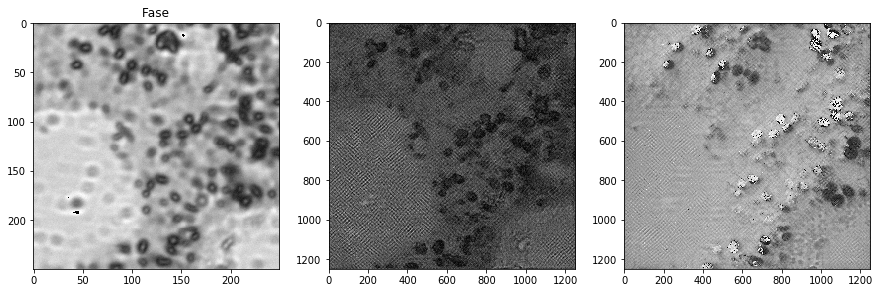

In [10]:
rm.height=135
plt.ion()
fig, ax = plt.subplots(1, 3, figsize=(15,10))
p0 = pmath.aberrated_pupil(0E-6, rm)
print(rm.patch_offset)
res, pupil = solve(delta_gk**1, centers, rm.no, rm.nsyn, max_iter=4, p0=p0,
                   method='stitching', results=results, microscope=rm)
solved_image = np.flip(res.gk, axis=0)
ax[0].imshow(np.abs(delta_gk[0]), cmap='gray')
ax[0].set_title('Imagen original')
ax[1].imshow(np.abs(res.gk), cmap='gray')
ax[0].set_title('Magnitud')
ax[2].imshow(np.angle(res.gk), cmap='gray')
ax[0].set_title('Fase')
plt.show()

[360  75] [-0.42   0.192]
86.64259753543627
108.66546867253349
122.61035000405667
125.998490268107
180.68789686530124
245.46540844287725
358.9368020062109
[360  75] [-0.42   0.192]
58.74293204325622
75.32992739703317
94.87855009502445
138.99171409434518
223.41656667070836
357.10575337008913
587.9395640996647
[360  75] [-0.42   0.192]
65.02619291130966
75.8072999505709
79.63567020961611
112.5431965230615
176.12233456471367
291.75481522692536
604.7188701238409
[360  75] [-0.42   0.192]
49.1415129912494
74.67283164858028
101.5862970212817
133.99493256905586
216.9012429752292
371.0836518414379
603.7324762798022
[360  75] [-0.42   0.192]
72.0988350639171
81.41102568251773
89.34213882014409
134.21048757573982
188.92367732893666
330.67684067098435


KeyboardInterrupt: 

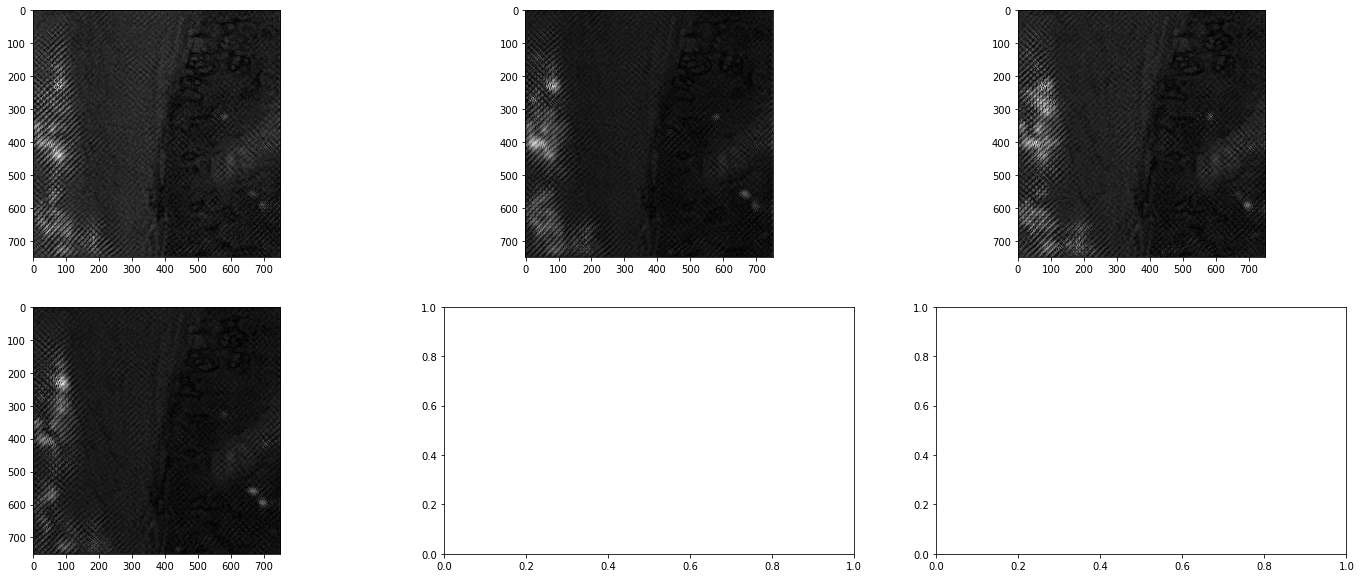

In [12]:
patch.image = np.flip(np.copy(delta_gk[0]), axis=0)
plt.ion()
fig, ax = plt.subplots(2, 3, figsize=(25,10))
axiter = iter(ax.ravel())
for h in [133, 134, 135, 136, 137, 138]:
    rm.height=h
    ax = next(axiter)1
    res, pupil = solve(delta_gk, centers, rm.no, rm.nsyn, max_iter=7, p0=p0,
                       method='stitching', results=results, microscope=rm)
    solved_image = np.flip(res.gk, axis=0)
    pic_hr.append(Patch(solved_image))
    ax.imshow(np.abs(res.gk), cmap='gray')

plt.show()

StopIteration: 

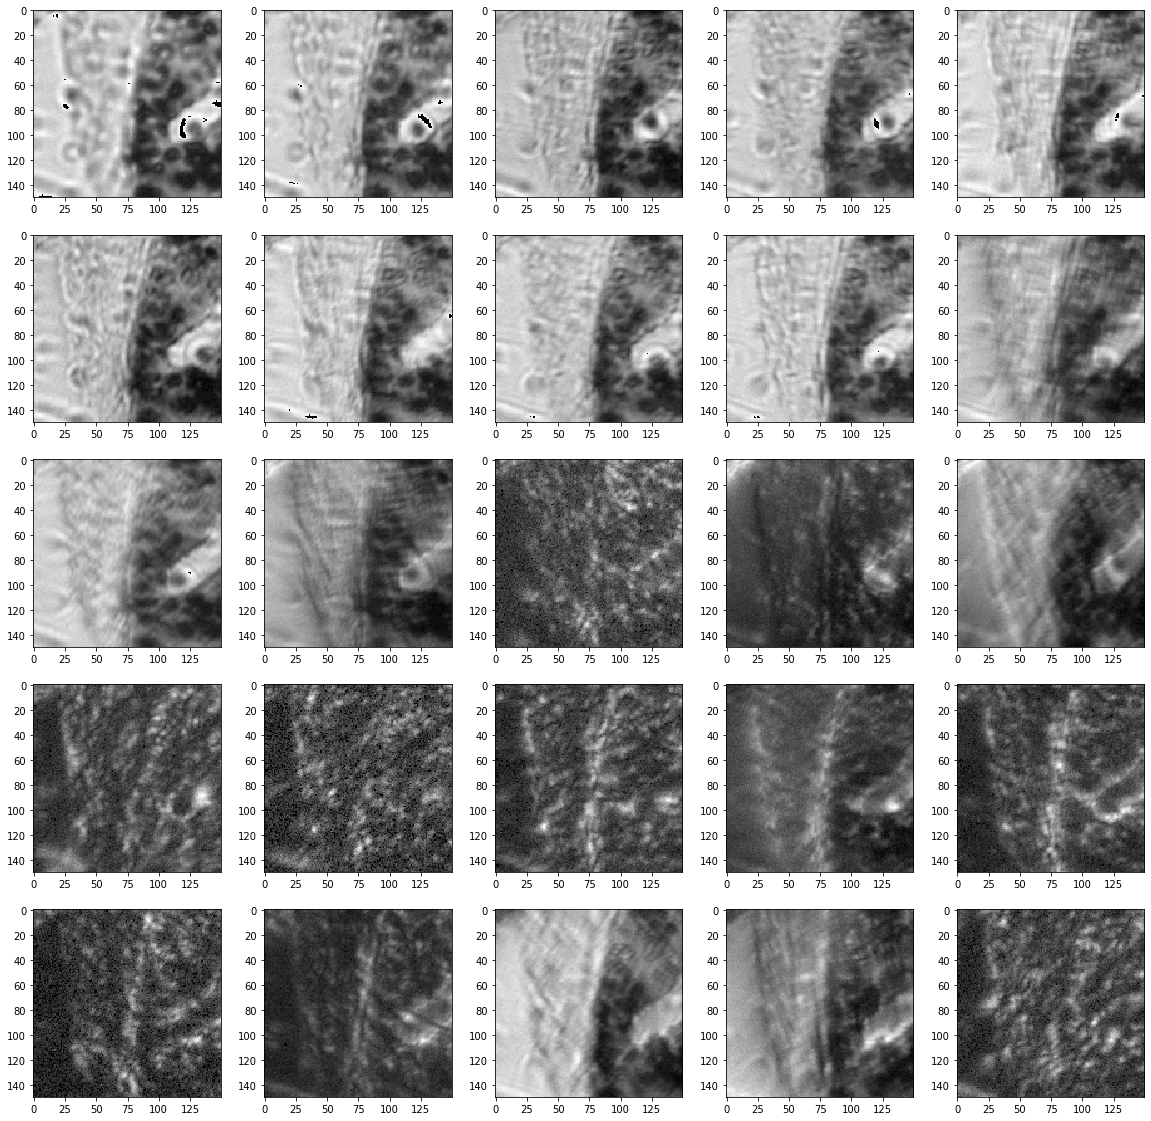

In [8]:
# patch = pic_lr.patches[17]
patch = pic_lr.patches[36]
rm.y0, rm.x0 = patch.center
delta_gk, centers = rm.get_phaseopt_input(mode='raw',
                    background_matrix=np.ones((32, 32))*1230)
fig, ax = plt.subplots(5, 5, figsize=(20,20))
axiter = iter(ax.ravel())
np.save('gk.npy', delta_gk)
for gk in delta_gk:
    ax = next(axiter)
    ax.imshow(np.abs(gk), cmap='gray')
plt.show()

[ 490 1415] [0.332 0.408]


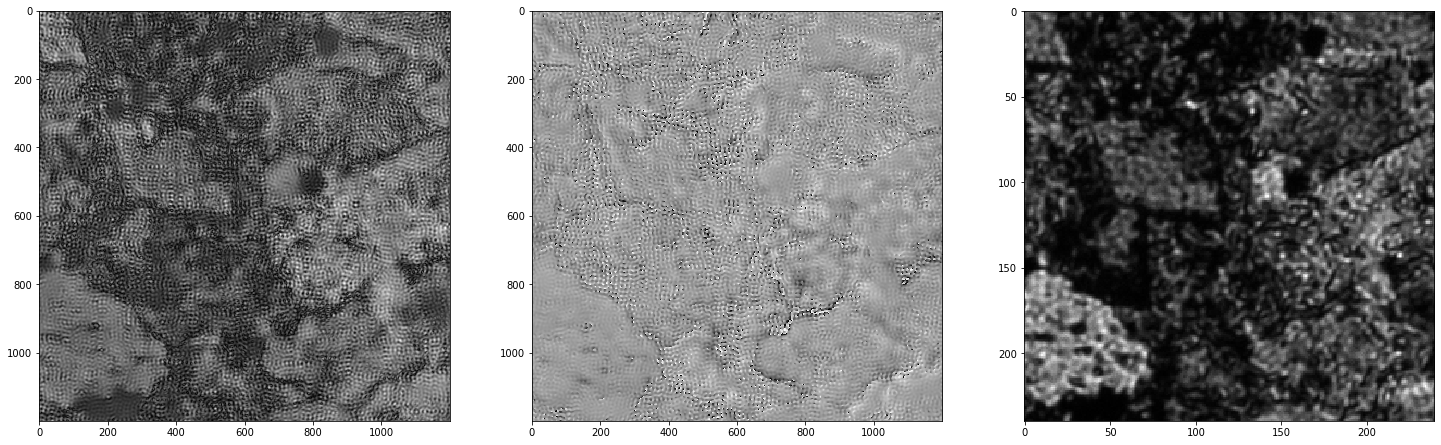

In [15]:
from skimage.filters import gaussian, median
from skimage.morphology import disk
from skimage.restoration import denoise_tv_chambolle

rm.height=136
plt.ion()
fig, ax = plt.subplots(1, 3, figsize=(25,15))
p0 = pmath.aberrated_pupil(0E-6, rm)
delta_gk = np.load('gk.npy')
exp_matrix = np.load('exposure_matrix.npy')
# delta_gk -= 1230
i=0
for center, gk in zip(centers, delta_gk):
    y, x = center
    gk[np.where(gk < 5)] = 0
    gk[np.where(gk > 2**16-3000)] = 0
    corr_factor = exp_matrix[y, x]
    gk = gk/corr_factor
#     gk = gaussian(gk, sigma=1.5)
#     res = denoise_tv_chambolle(gk, weight=100)
#     delta_gk[i] = median(gk, disk(1))
    delta_gk[i] = gk
    i += 1
res, pupil = solve(delta_gk, centers, rm.no, rm.nsyn, max_iter=15, p0=p0,
                   method='stitching', results=results, microscope=rm)
solved_image = np.flip(res.gk, axis=0)
ax[0].imshow(np.abs(res.gk), cmap='gray')
ax[1].imshow(np.angle(res.gk), cmap='gray')
ax[2].imshow(delta_gk[0], cmap='gray')

plt.show()